In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import random
from difflib import SequenceMatcher
from transformers import CLIPModel, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler

In [ ]:
num_inference_steps = 50
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_path_clip = "openai/clip-vit-large-patch14"
clip_tokenizer = CLIPTokenizer.from_pretrained(model_path_clip, cache_dir="./cache")
clip_model = CLIPModel.from_pretrained(model_path_clip, torch_dtype=torch.float16, cache_dir="./cache")
clip = clip_model.text_model

model_path_diffusion = "CompVis/stable-diffusion-v1-4"
unet = UNet2DConditionModel.from_pretrained(model_path_diffusion, subfolder="unet", revision="fp16", torch_dtype=torch.float16)
vae = AutoencoderKL.from_pretrained(model_path_diffusion, subfolder="vae", revision="fp16", torch_dtype=torch.float16)

unet.to(device)
vae.to(device)
clip.to(device)

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)


class Pipeline:
    def __init__(self, vae, unet, tokenizer, text_encoder, scheduler):
        self.vae = vae
        self.unet = unet
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.scheduler = scheduler
pipe = Pipeline(vae, unet, clip_tokenizer, clip, scheduler)

In [ ]:
# Prompt to prompt controller
class Controller:
    def __init__(self, text_inputs, prompt_edit_token_weights=[], tokenizer=None, device="cuda", dtype=torch.float16):
        assert len(text_inputs) == 2, "Currently only support one base prompt and one edited prompt."
        self.device = device
        self.dtype = dtype
        self.is_ptp = False
        self.is_att_cross_replace = False
        self.is_att_self_replace = False
        self.att_weight = self.building_att_weight(prompt_edit_token_weights, tokenizer)
        self.att_mask, self.indices_base = self.building_att_replace(text_inputs[0], text_inputs[1], tokenizer)


    def building_att_replace(self, text_input_base, text_input_edit, tokenizer):
        max_len = tokenizer.model_max_length
        masks = torch.zeros(max_len)
        indices_base = torch.zeros(max_len, dtype=torch.long)
        indices_edit = torch.arange(max_len, dtype=torch.long)

        for name, x0, x1, y0, y1 in SequenceMatcher(None, text_input_base, text_input_edit).get_opcodes():
            if y0 < max_len:
                if name == "equal" or (name == "replace" and x1 - x0 == y1 - y0):
                    masks[y0: y1] = 1
                    indices_base[x0: x1] = indices_edit[y0: y1]
        return masks.to(self.device, dtype=self.dtype), indices_base.to(self.device)
                
                
    def building_att_weight(self, weight_tuples, tokenizer):
        max_len = tokenizer.model_max_length
        weights = torch.ones(max_len)
        for i, w in weight_tuples:
            weights[i] = w
        return weights.to(self.device, dtype=self.dtype)


    def __call__(self, att_maps, heads, is_cross):
        if self.is_ptp == False: 
            return att_maps
        is_att_replace = self.is_att_cross_replace if is_cross else self.is_att_self_replace
        att_base = att_maps[0: heads]
        att_edit = att_maps[heads:]

        if is_att_replace:
            if is_cross:
                att_base_mapped = torch.index_select(att_base, -1, self.indices_base)
                att_edit = att_edit * (1 - self.att_mask) + att_base_mapped * self.att_mask
            else:
                att_edit = att_base.clone()

        if is_cross:
            att_edit = att_edit * self.att_weight

        return torch.cat([att_base, att_edit])


In [315]:
def register_attention_control(model, outer):
    def reshape_heads_to_batch_dim(self, tensor):
        batch_size, seq_len, dim = tensor.shape
        head_size = self.heads
        tensor = tensor.reshape(batch_size, seq_len, head_size, dim // head_size)
        tensor = tensor.permute(0, 2, 1, 3).reshape(batch_size * head_size, seq_len, dim // head_size)
        return tensor

    def reshape_batch_dim_to_heads(self, tensor):
        batch_size, seq_len, dim = tensor.shape
        head_size = self.heads
        tensor = tensor.reshape(batch_size // head_size, head_size, seq_len, dim)
        tensor = tensor.permute(0, 2, 1, 3).reshape(batch_size // head_size, seq_len, dim * head_size)
        return tensor
    
    def forward(self, x, encoder_hidden_states=None, attention_mask=None):
        context = encoder_hidden_states
        mask = attention_mask
        batch_size, sequence_length, dim = x.shape
        h = self.heads
        q = self.to_q(x)
        is_cross = context is not None
        context = context if is_cross else x
        k = self.to_k(context)
        v = self.to_v(context)
        q = self.reshape_heads_to_batch_dim(q)
        k = self.reshape_heads_to_batch_dim(k)
        v = self.reshape_heads_to_batch_dim(v)

        sim = torch.einsum("b i d, b j d -> b i j", q, k) * self.scale

        if mask is not None:
            mask = mask.reshape(batch_size, -1)
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = mask[:, None, :].repeat(h, 1, 1)
            sim.masked_fill_(~mask, max_neg_value)

        attn = sim.softmax(dim=-1)
        if outer.controller is not None:
            attn = outer.controller(attn, h, is_cross)
        out = torch.einsum("b i j, b j d -> b i d", attn, v)
        out = self.reshape_batch_dim_to_heads(out)
        return self.to_out[0](out) # skip the dropout

    def register_recr(net_):
        cnt = 0
        if net_.__class__.__name__ == 'BasicTransformerBlock':
            net_.attn1.reshape_heads_to_batch_dim = reshape_heads_to_batch_dim.__get__(net_.attn1)
            net_.attn1.reshape_batch_dim_to_heads = reshape_batch_dim_to_heads.__get__(net_.attn1)
            net_.attn1.forward = forward.__get__(net_.attn1)

            net_.attn2.reshape_heads_to_batch_dim = reshape_heads_to_batch_dim.__get__(net_.attn2)
            net_.attn2.reshape_batch_dim_to_heads = reshape_batch_dim_to_heads.__get__(net_.attn2)
            net_.attn2.forward = forward.__get__(net_.attn2)
            return 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                cnt += register_recr(net__)
        return cnt

    sub_nets = model.named_children()
    count = 0
    for net in sub_nets:
        if "down" in net[0]:
            count += register_recr(net[1])
        elif "up" in net[0]:
            count += register_recr(net[1])
        elif "mid" in net[0]:
            count += register_recr(net[1])
    print(count)


def view_images(images, resize_to_min_height=True):
    if resize_to_min_height:
        min_height = min(img.height for img in images)
        images = [
            img.resize((int(img.width * min_height / img.height), min_height))
            for img in images
        ]

    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    new_img = Image.new("RGB", (total_width, max_height))

    x_offset = 0
    for img in images:
        new_img.paste(img, (x_offset, 0))
        x_offset += img.width

    return new_img


In [316]:
class NullTextInversion:
    def __init__(self, pipe, num_inference_steps=50, guidance_scale=7.5, device="cuda:0", dtype=torch.float16):
        self.dtype = dtype
        self.device = device
        self.guidance_scale = guidance_scale
        self.ddim_steps = num_inference_steps
        self.vae = pipe.vae
        self.unet = pipe.unet
        self.tokenizer = pipe.tokenizer
        self.text_encoder = pipe.text_encoder
        self.scheduler = pipe.scheduler
        self.scheduler.set_timesteps(num_inference_steps)
        self.controller = None

        register_attention_control(self.unet, self)

    
    @torch.no_grad()
    def encode_context(self, prompt):
        text_inputs = self.tokenizer([prompt], padding="max_length", max_length=self.tokenizer.model_max_length, return_tensors="pt")
        text_embeddings = self.text_encoder(text_inputs.input_ids.to(self.device))[0]
        
        null_text_inputs = self.tokenizer([""], padding="max_length", max_length=self.tokenizer.model_max_length, return_tensors="pt")
        null_text_embeddings = self.text_encoder(null_text_inputs.input_ids.to(self.device))[0]
        return torch.cat([text_embeddings, null_text_embeddings], dim=0)

    @torch.no_grad()
    def image_to_latent(self, image):
        if isinstance(image, Image.Image):
            image = np.array(image)
        image = torch.from_numpy(image).float() / 127.5 - 1
        image = image.permute(2, 0, 1).unsqueeze(0).to(self.device)
        image = image.to(self.vae.dtype)
        latent = self.vae.encode(image).latent_dist.sample()
        latent = latent * self.vae.config.scaling_factor
        return latent

    @torch.no_grad()
    def latent_to_image(self, latent):
        latent = latent / self.vae.config.scaling_factor
        image = self.vae.decode(latent).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        image = (image * 255).astype("uint8")
        return image

    def prev_step(self, latent, timestep, noise_pred):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.ddim_steps
        alpha_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prev_t = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        pred_x0 = (latent - torch.sqrt(1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)
        dir_xt = torch.sqrt(1 - alpha_prev_t) * noise_pred
        prev_latent = torch.sqrt(alpha_prev_t) * pred_x0 + dir_xt
        return prev_latent

    def next_step(self, latent, timestep, noise_pred):
        timestep, next_timestep = timestep - self.scheduler.config.num_train_timesteps // self.ddim_steps, timestep
        alpha_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_next_t = self.scheduler.alphas_cumprod[next_timestep]
        pred_x0 = (latent - torch.sqrt(1 - alpha_t) * noise_pred) / torch.sqrt(alpha_t)
        dir_xt = torch.sqrt(1 - alpha_next_t) * noise_pred
        next_latent = torch.sqrt(alpha_next_t) * pred_x0 + dir_xt
        return next_latent


    @torch.no_grad()
    def ddim_inversion(self, image, context):
        latent = self.image_to_latent(image).to(self.device)
        cond_embedding, uncond_embedding = context.chunk(2)

        all_latents = [latent.cpu()]
        latent = latent.clone().detach()
        for i in range(self.ddim_steps):
            t = self.scheduler.timesteps[len(self.scheduler.timesteps) - i - 1]
            noise_pred = self.unet(latent, t, encoder_hidden_states=cond_embedding).sample
            latent = self.next_step(latent, t, noise_pred)
            all_latents.append(latent.cpu())
        
        return all_latents

    
    def null_optimization(self, all_latents, context, num_uncond_train_steps, epsilon):
        uncond_embedding_list = []
        cond_embedding, uncond_embedding = context.chunk(2)
        latent_cur = all_latents[-1].to(self.device)

        for i in range(self.ddim_steps):
            print(i)
            t = self.scheduler.timesteps[i]
            latent_prev = all_latents[len(all_latents) - i - 2].to(self.device)

            uncond_embedding = uncond_embedding.clone().detach()
            uncond_embedding.requires_grad = True
            optimizer = torch.optim.Adam([uncond_embedding], lr=1e-2 * (1. - i / 100.))

            with torch.no_grad():
                pred_cond_noise = self.unet(latent_cur, t, encoder_hidden_states=cond_embedding).sample

            for _ in range(num_uncond_train_steps):
               pred_uncond_noise = self.unet(latent_cur, t, encoder_hidden_states=uncond_embedding).sample
               pred_noise = self.guidance_scale * pred_cond_noise + (1 - self.guidance_scale) * pred_uncond_noise
               pred_latent_prev = self.prev_step(latent_cur, t, pred_noise)
               loss = F.mse_loss(pred_latent_prev, latent_prev)
               optimizer.zero_grad()
               loss.backward()
               optimizer.step()
               if loss.item() < epsilon + i * 2e-5:
                    break

            with torch.no_grad():
                uncond_embedding_list.append(uncond_embedding.detach().cpu()) 
                pred_uncond_noise = self.unet(latent_cur, t, encoder_hidden_states=uncond_embedding).sample
                noise_pred = self.guidance_scale * pred_cond_noise + (1 - self.guidance_scale) * pred_uncond_noise
                latent_cur = self.prev_step(latent_cur, t, noise_pred)
        
        return latent_cur, uncond_embedding_list


    def invert(self, img, prompt, num_uncond_train_steps=10, early_stop_epsilon=1e-5):
        context = self.encode_context(prompt)
        all_latents = self.ddim_inversion(img, context)
        latent, uncond_embedding_list = self.null_optimization(all_latents, context, num_uncond_train_steps, early_stop_epsilon)
        rec_img = self.latent_to_image(latent)
        rec_img = Image.fromarray(rec_img)
        return rec_img, latent, uncond_embedding_list
    

    def find_token_indices_(self, text, word, weight=1):
        split_text = text.split(" ")
        word_place = [i for i, wrd in enumerate(split_text) if word == wrd]
        out = []
        if len(word_place) > 0:
            words_encode = [self.tokenizer.decode([item]) for item in self.tokenizer.encode(text)][1:-1]
            cur_len, ptr = 0, 0
            for i in range(len(words_encode)):
                    cur_len += len(words_encode[i])
                    if ptr in word_place:
                        out.append([(i + 1), weight])
                    if cur_len >= len(split_text[ptr]):
                        ptr += 1
                        cur_len = 0
        return out
    
    def find_token_indices(self, text, word_weights):
        out = []
        for word, weight in word_weights:
            out += self.find_token_indices_(text, word, weight)
        return out


    @torch.no_grad()
    def prompt2prompt(self, prompt_base, prompt_edit, word_weights=[], self_att_replace_scale=[], cross_att_replace_scale=[], 
                      uncond_embedding_list=None, init_latent=None, width=512, height=512, seed=None):
        assert len(self_att_replace_scale) == 2, "self_att_replace_scale should be a tuple of two elements."
        assert len(cross_att_replace_scale) == 2, "cross_att_replace_scale should be a tuple of two elements."

        prompt_edit_token_weights = self.find_token_indices(prompt_edit, word_weights)

        prompts = [prompt_base, prompt_edit]
        text_inputs_cond = self.tokenizer(prompts, padding="max_length", max_length=self.tokenizer.model_max_length, return_tensors="pt").input_ids
        text_embeddings_cond = clip(text_inputs_cond.to(self.device))[0]

        if uncond_embedding_list is None:
            text_inputs_uncond = self.tokenizer([""], padding="max_length", max_length=self.tokenizer.model_max_length, return_tensors="pt").input_ids
            text_embeddings_uncond = clip(text_inputs_uncond.to(self.device))[0]

        if init_latent is None:
            if seed is None:
                seed = random.randrange(2**32 - 1)
            latent = torch.randn((1, self.unet.config.in_channels, height // 8, width // 8), generator=torch.manual_seed(seed))
            latent = latent * self.scheduler.init_noise_sigma
        else:
            latent = init_latent.clone()
        latents = torch.cat([latent] * 2).to(self.device).to(dtype=self.dtype)

        self.controller = Controller(text_inputs = text_inputs_cond, prompt_edit_token_weights=prompt_edit_token_weights, tokenizer=self.tokenizer, device=self.device, dtype=self.dtype)    
        
        for i in range(self.ddim_steps):
            scale_i = i / self.ddim_steps
            t = self.scheduler.timesteps[i]
            latents = self.scheduler.scale_model_input(latents, t)
        
            self.controller.is_ptp = False
            cur_uncond_embedding = uncond_embedding_list[i].to(self.device) if uncond_embedding_list is not None else text_embeddings_uncond
            noise_pred_uncond = self.unet(latents, t, encoder_hidden_states=cur_uncond_embedding.repeat(2, 1, 1)).sample
            noise_pred_uncond_base, noise_pred_uncond_edit = noise_pred_uncond.chunk(2)

            self.controller.is_ptp = True
            self.controller.is_att_cross_replace = False
            self.controller.is_att_self_replace = False
            if cross_att_replace_scale[0] <= scale_i <= cross_att_replace_scale[1]:
                self.controller.is_att_cross_replace = True
            if self_att_replace_scale[0] <= scale_i <= self_att_replace_scale[1]:
                self.controller.is_att_self_replace = True
            noise_pred_cond = self.unet(latents, t, encoder_hidden_states=text_embeddings_cond).sample
            noise_pred_cond_base, noise_pred_cond_edit = noise_pred_cond.chunk(2)

            noise_pred_base = self.guidance_scale * noise_pred_cond_base + (1 - self.guidance_scale) * noise_pred_uncond_base
            noise_pred_edit = self.guidance_scale * noise_pred_cond_edit + (1 - self.guidance_scale) * noise_pred_uncond_edit

            latents_base = self.prev_step(latents[0], t, noise_pred_base)
            latents_edit = self.prev_step(latents[1], t, noise_pred_edit)
            latents = torch.cat([latents_base, latents_edit])

        base_img = Image.fromarray(self.latent_to_image(latents[0].unsqueeze(0)))
        edit_img = Image.fromarray(self.latent_to_image(latents[1].unsqueeze(0)))
        return base_img, edit_img
    
            

null_text_inversion = NullTextInversion(pipe, num_inference_steps=num_inference_steps)

16


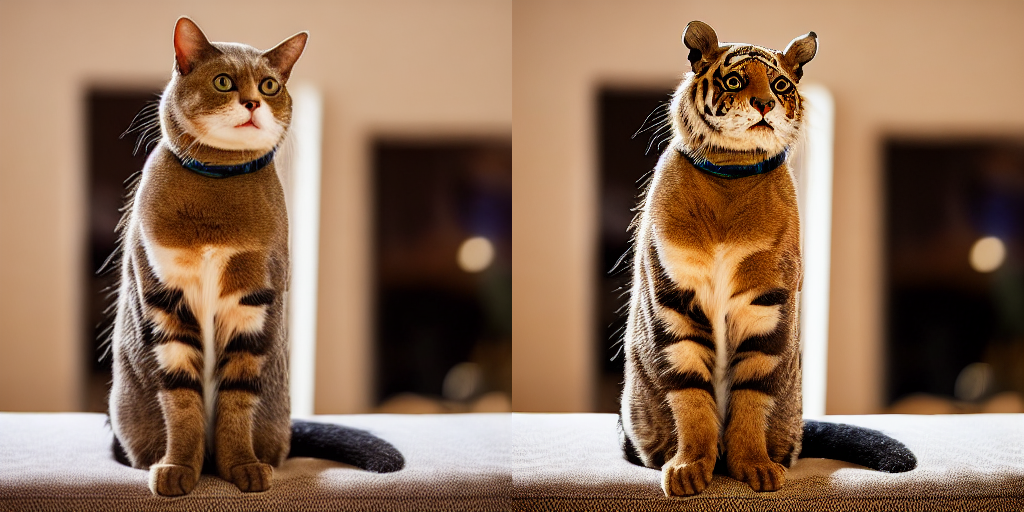

In [278]:
prompts = ["a cat sitting next to a mirror",
           "a tiger sitting next to a mirror"
        ]
base_img, edit_img = null_text_inversion.prompt2prompt(prompts[0], prompts[1],
                                                             self_att_replace_scale = [0.0, 0.8], 
                                                             cross_att_replace_scale = [0.0, 0.6])

view_images([base_img, edit_img])

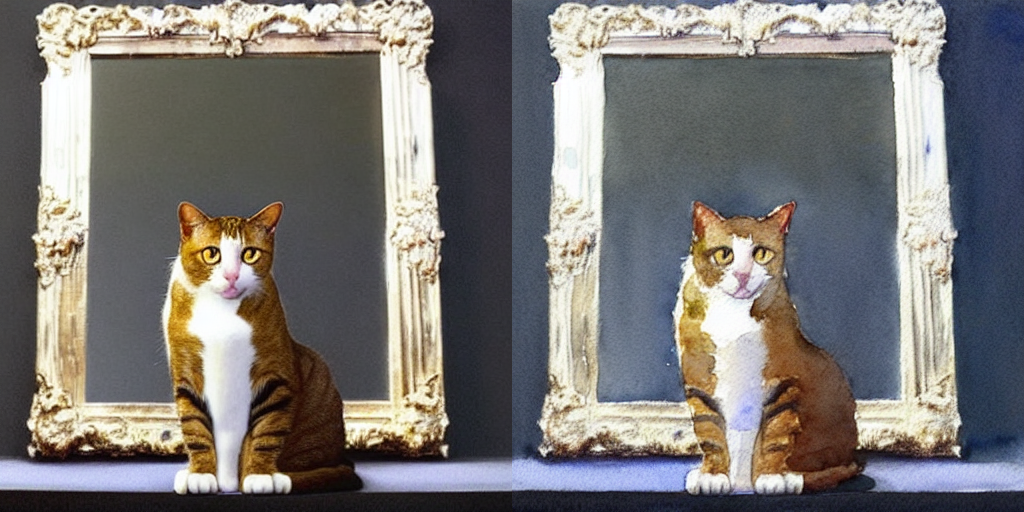

In [281]:
prompts = ["a cat sitting next to a mirror",
           "watercolor painting of a cat sitting next to a mirror"
        ]
base_img, edit_img = null_text_inversion.prompt2prompt(prompts[0], prompts[1],
                                                             word_weights = [("watercolor", 5)], # Amplify the word "watercolor" by 5 times
                                                             self_att_replace_scale = [0.0, 0.8], 
                                                             cross_att_replace_scale = [0.0, 0.6])

view_images([base_img, edit_img])

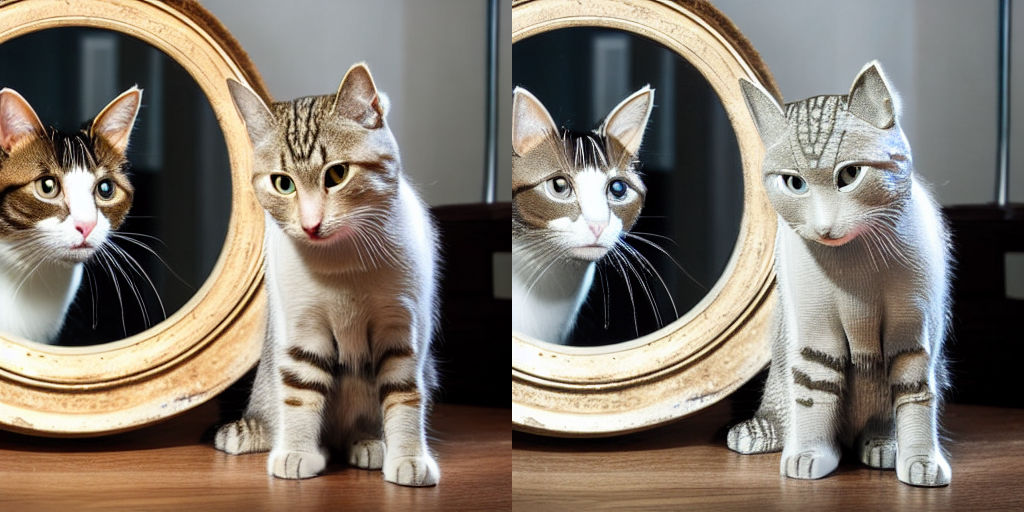

In [ ]:
prompts = ["a cat sitting next to a mirror",
           "a silver cat sculpture sitting next to a mirror"
        ]
base_img, edit_img = null_text_inversion.prompt2prompt(prompts[0], prompts[1],
                                                        word_weights = [("silver", 2), ("sculpture", 2)],
                                                        self_att_replace_scale = [0.0, 0.8], 
                                                        cross_att_replace_scale = [0.0, 0.6])
view_images([base_img, edit_img])

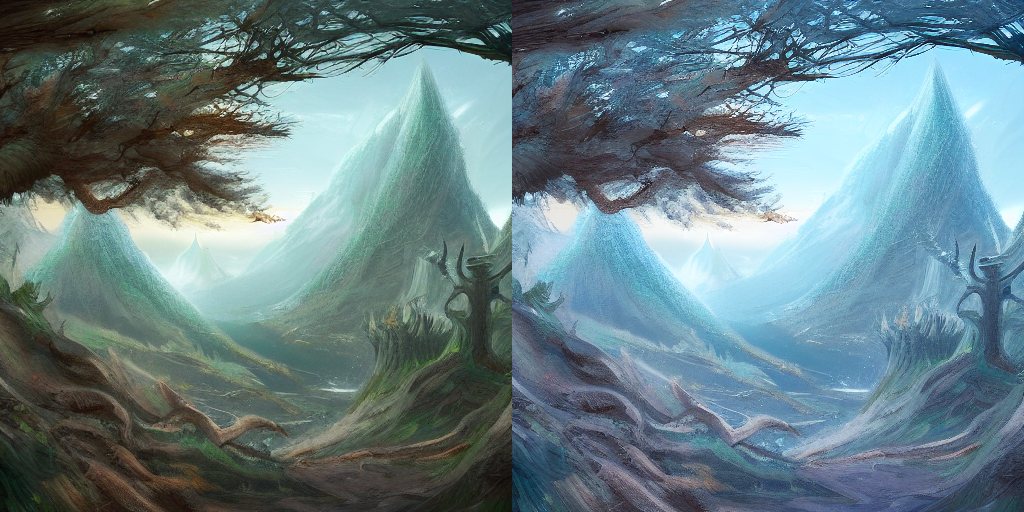

In [ ]:
prompts = ["A fantasy landscape with a pine forest, trending on artstation", 
           "A winter fantasy landscape with a pine forest, trending on artstation"
        ]
base_img, edit_img = null_text_inversion.prompt2prompt(prompts[0], prompts[1],
                                                        self_att_replace_scale = [0.0, 0.8], 
                                                        cross_att_replace_scale = [0.0, 0.6])
view_images([base_img, edit_img])

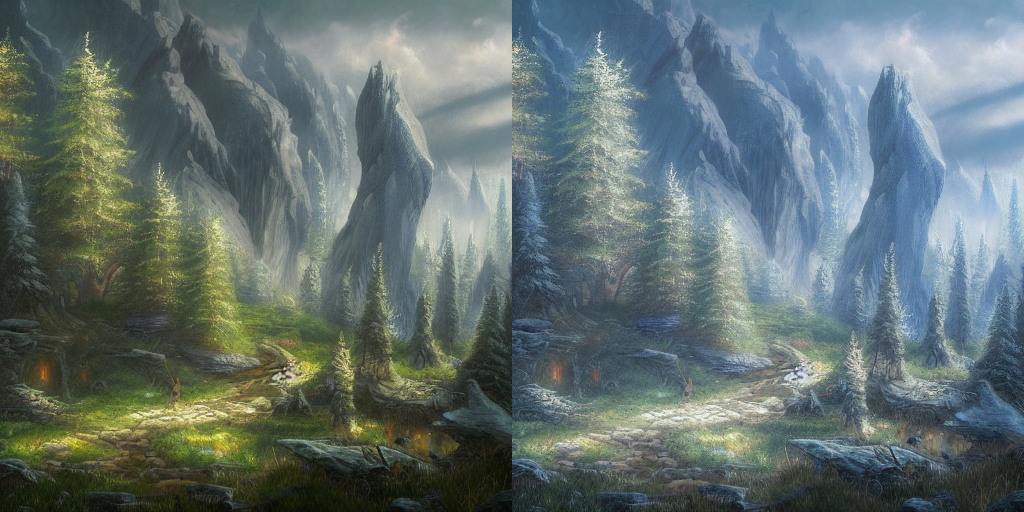

In [ ]:
prompts = ["A fantasy landscape with a pine forest, trending on artstation", 
           "A winter fantasy landscape with a pine forest, trending on artstation"
        ]
base_img, edit_img = null_text_inversion.prompt2prompt(prompts[0], prompts[1],
                                                        word_weights = [("winter", -4)], # Decrease the word "winter" by 4 times
                                                        self_att_replace_scale = [0.0, 0.8], 
                                                        cross_att_replace_scale = [0.0, 0.6])
view_images([base_img, edit_img])

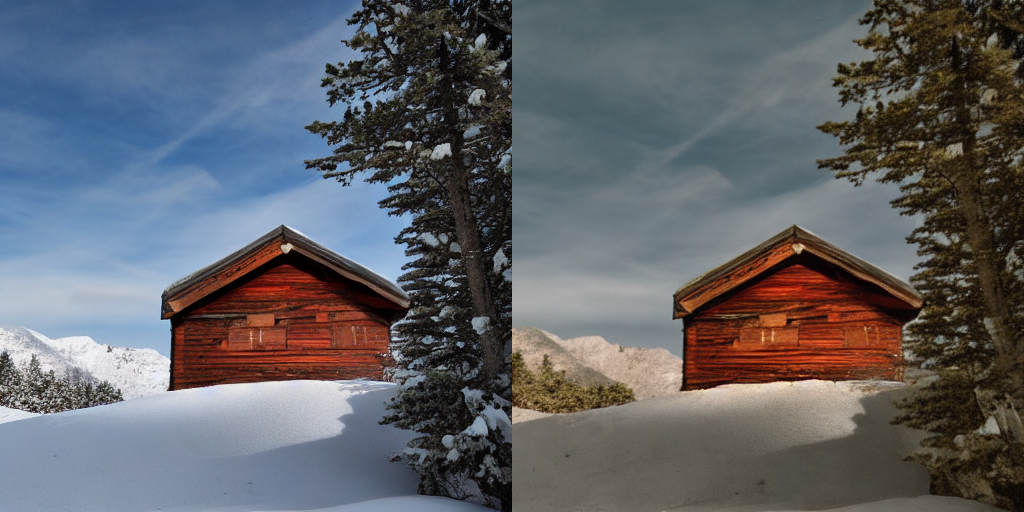

In [317]:
prompts = [
    "A photo of a house on a snowy mountain", 
    "A photo of a house on a snowy mountain"
]
base_img, edit_img = null_text_inversion.prompt2prompt(prompts[0], prompts[1],
                                                        word_weights = [("snowy", -8)], 
                                                        self_att_replace_scale = [0.0, 0.8], 
                                                        cross_att_replace_scale = [0, 0.6])
view_images([base_img, edit_img])